In [1]:
# This is a fix for vscode, because it doesn't like 
# julia docstrings for whatever reason, and throws a `Katex` error.
using Markdown
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [2]:
push!(LOAD_PATH, "../src");
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src");
using BenchmarkTools;
using CUDA
using LaTeXStrings
using Colors, Plots, Images;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using Fmt # Python-style f-strings
using MyUtils
using GenDistributionZoo: ProductDistribution, diagnormal
mvuniform = ProductDistribution(uniform);

include("../src/pose.jl");
include("src/plotting.jl")

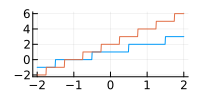

In [3]:
#nbx
"""
Discretize into bins of diameter r, bin-centers lie 
at `z - k*r` for intergers `k`.
"""
quantize(x, r; zero=0) = Int.(floor.((x .+ r./2 .- zero)./r))

xs  = -2:0.01:2
# ----------------- 
plot(size=(200,100))
plot!(xs, quantize.(xs, 1.0; zero=-1), legend=nothing)
plot!(xs, quantize.(xs, 0.5; zero=-1), legend=nothing)

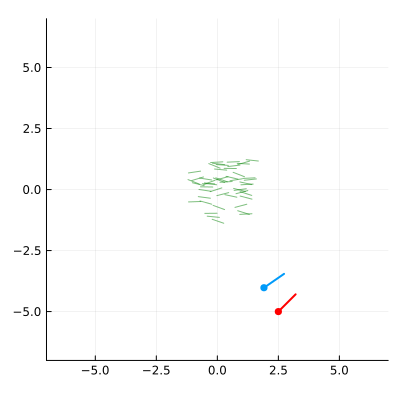

In [5]:
rx = 2.5
rθ = 45/180*π
v  = [rx, rx, rθ]
cell_args =([-rx/2,-rx/2,-rθ/2],[rx/2,rx/2,rθ/2])

p0 = Pose([0,0],0)
v0 = Vector(p0)
p  = Pose(uniform(-5.,5.),uniform(-5.,5.),uniform(-π,π))

I  = quantize.(Vector(p), [rx,rx,rθ])
qi = Pose(I.*v)
qs  = Pose.([I.*v0 + mvuniform(cell_args...) for i=1:50])

# ------------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing,
    xlim=(-7,7), ylim=(-7,7),
    xticks=[0:-rx:-5;rx:rx:5], yticks=[0:-rx:-5;rx:rx:5],
    )
plot!(qs, r=.5, c=:green, alpha=0.5)
scatter!(qi, r=1., c=:red, linewidth=2)
scatter!(p, r=1., c=col[1], linewidth=2)


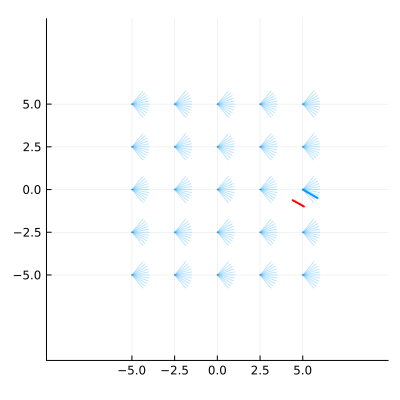

In [6]:
p0 = Pose([0,0],0)
v0 = Vector(p0)

rx = 2.5
rθ = 10/180*π
v  = [rx, rx, rθ]

kx, ky, kθ = 5,5,10
ix, iy, iθ = div(kx,2),div(ky,2),div(kθ,2)
v1 = v0 - [ix+1,iy+1,iθ+1].*v

shape = 2 .* (ix,iy,iθ) .+ 1
vs = map(I -> v1 + [Tuple(I)...].*v, CartesianIndices(shape));
ps = map(Pose, vs);

p  = Pose(uniform(-5.,5.),uniform(-5.,5.),uniform(v1[3]+rθ,v1[3]+kθ*rθ))
I  = quantize(Vector(p), [rx,rx,rθ], zero=v1)

# ------------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing,
    xlim=(-10,10), ylim=(-10,10),
    xticks=[0:-rx:-5;rx:rx:5], yticks=[0:-rx:-5;rx:rx:5],
    )


plot!(ps[:], r=1., c=col[1], linewidth=1, alpha=0.25)
plot!(ps[CartesianIndex(I...)], r=1., c=col[1], linewidth=2)
plot!(p, r=.75,c=:red, linewidth=2)

In [9]:
# mutable struct PoseGrid
#     Inf64
# end

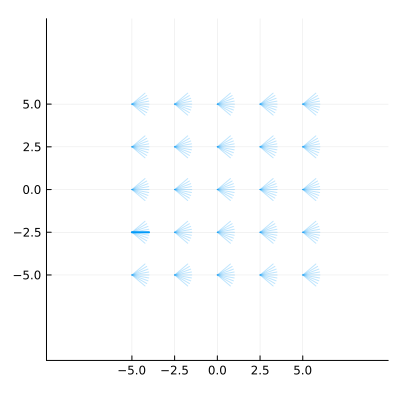

In [7]:
function pose_grid(v0, r, k)
    i = Tuple(div.(k,2))
    ell = v0 - (i.+1).*r
    shape = 2 .* i .+ 1
    C = CartesianIndices(shape)
    vs = map(I -> ell + [Tuple(I)...].*r, C);
    ps = map(Pose, vs);
    ps
end


function grid_index(p, v0, r, k)
    i = Tuple(div.(k,2))
    l = v0 - (i.+1).*r
    quantize(Vector(p), r, zero=l)
end

rx = 2.5
rθ = 10/180*π
r = [rx,rx,rθ]
k = [5,5,9]
ps = pose_grid(v0, r, k)

p  = Pose(uniform(-5.,5.),uniform(-5.,5.),uniform(-r[3],r[3]))
I  = grid_index(p, v0, r, k)

# ------------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing,
    xlim=(-10,10), ylim=(-10,10),
    xticks=[0:-rx:-5;rx:rx:5], yticks=[0:-rx:-5;rx:rx:5],
    )


plot!(ps[:], r=1., c=col[1], linewidth=1, alpha=0.25)
plot!(ps[CartesianIndex(I...)], r=1., c=col[1], linewidth=2)
# plot!(p, r=.75,c=:red, linewidth=2)/

In [8]:
@gen function grid_proposal(tr, t, r, k)
    v_x  = tr[t => :pose => :x]
    v_hd = tr[t => :pose => :hd]
    v_0 = [v_x;v_hd]

    k′    = Tuple(div.(k,2))
    z     = v_0 - (k′.+1).*r
    shape = 2 .* k′ .+ 1

    cs = CartesianIndices(shape)
    vs = map(I -> z + [Tuple(I)...].*r, cs)

    n = prod(size(cs))
    probs = fill(1/n,n)

    j ~ categorical(probs)
    w_min = vs[j]-r/2
    w_max = vs[j]+r/2
    x  = {t => :pose => :x}  ~ mvuniform(w_min[1:2],w_max[1:2])
    hd = {t => :pose => :hd} ~ uniform(w_min[3], w_max[3])

    return [x;hd], j
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing], var"##grid_proposal#327", Bool[0, 0, 0, 0], false)

In [9]:
shape = (2,3,4)
I = CartesianIndex(shape)
i = LinearIndices(shape)[I]

24

In [10]:
# (new_trace, bwd_choices::ChoiceMap, weight) = involution(trace::Trace, fwd_choices::ChoiceMap, fwd_retval, fwd_args::Tuple)
function involution(tr1, ch2, re2, args)
    t,r,k = args

    v1_x  = tr1[t => :pose => :x]
    v1_hd = tr1[t => :pose => :hd]
    v1 = [v1_x;v1_hd]

    v2 = [ ch2[t => :pose => :x];ch2[t => :pose => :hd]]
    ch = choicemap()
    ch[t => :pose => :x]  = v2[1:2]
    ch[t => :pose => :hd] = v2[3]
    tr2, = Gen.update(tr, ch)

    
    k′    = Tuple(div.(k,2))
    z     = v2 .- (k′.+1).*r
    shape = 2 .* k′ .+ 1
    
    I  = quantize(v1, r, zero=z)
    j1 = LinearIndices(shape)[I...]
    
    ch1 = choicemap()
    ch1[:j] = j1
    ch1[t => :pose => :x]  = v1_x
    ch1[t => :pose => :hd] = v1_hd

    w = get_score(tr2) - get_score(tr1)
    tr2, ch1 , w
end



involution (generic function with 1 method)

In [11]:
@gen function model(t)
    x  = {t => :pose => :x } ~ mvuniform([0,0],[1,1])
    hd = {t => :pose => :hd} ~ uniform(-π,π)
    return Pose(x,hd) 
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##model#328", Bool[0], false)

  5.433753 seconds (9.87 M allocations: 637.283 MiB, 3.34% gc time, 99.94% compilation time)
true


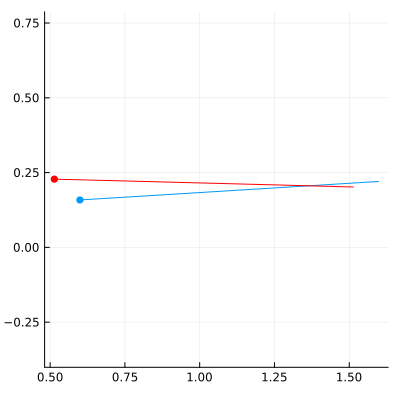

In [12]:
t=1
tr = simulate(model, (t,))

ch = choicemap()
ch[t => :pose => :x] = rand(2)
ch[t => :pose => :hd] = rand()
tr, = Gen.update(tr, ch)

rx = 0.05
rθ = 5/180*π
r = [rx,rx,rθ]
k = [5,5,9]


@time tr′, accepted = metropolis_hastings(tr, grid_proposal, (t,r,k), involution)

p = tr[]
q = tr′[]
println(accepted)

# ------------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
scatter!(p, c=col[1])
scatter!(q, c=:red)
